In [6]:
import pandas as pd

# Load the dataset
data = pd.read_csv("/content/Data.csv")  # Replace with your dataset file
print(data.head())

                                                text         intent
0   listen to westbam alumb allergic on google music      playmusic
1         add step to me to the 50 clásicos playlist  addtoplaylist
2  i give this current textbook a rating value of...       ratebook
3               play the song little robin redbreast      playmusic
4  please add iris dement to my playlist this is ...  addtoplaylist


In [7]:
import re

def clean_text(text):
    if not isinstance(text, str):
        return text  # Handle non-string values
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning to text and intent columns
data['text'] = data['text'].apply(clean_text)
data['intent'] = data['intent'].apply(clean_text)

# Check for missing values
print(data.isnull().sum())

text      0
intent    0
dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode intent labels
label_encoder = LabelEncoder()
data['intent_encoded'] = label_encoder.fit_transform(data['intent'])
print(data.head())

                                                text         intent  \
0   listen to westbam alumb allergic on google music      playmusic   
1         add step to me to the 50 clásicos playlist  addtoplaylist   
2  i give this current textbook a rating value of...       ratebook   
3               play the song little robin redbreast      playmusic   
4  please add iris dement to my playlist this is ...  addtoplaylist   

   intent_encoded  
0              35  
1               0  
2              38  
3              35  
4               0  


In [9]:
from sklearn.model_selection import train_test_split

# Split the data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Training set: {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")
print(f"Test set: {len(test_df)} examples")

Training set: 33657 examples
Validation set: 3740 examples
Test set: 9350 examples


In [10]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_data(df, tokenizer, max_length=64):
    return tokenizer(
        df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Tokenize training, validation, and test data
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

In [11]:
import torch

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = IntentDataset(train_encodings, train_df['intent_encoded'].tolist())
val_dataset = IntentDataset(val_encodings, val_df['intent_encoded'].tolist())
test_dataset = IntentDataset(test_encodings, test_df['intent_encoded'].tolist())

In [12]:
from transformers import BertForSequenceClassification

# Load pre-trained BERT for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_encoder.classes_)  # Number of unique intents
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Output directory
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,  # Batch size for evaluation
    warmup_steps=500,  # Number of warmup steps
    weight_decay=0.01,  # Strength of weight decay
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="epoch"  # Evaluate after each epoch
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
from transformers import Trainer

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [15]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hirudikaanupama3 (hirudikaanupama3-robert-gordon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.046300,0.067466
2,0.000900,0.043260
3,0.000500,0.043559


<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a 

TrainOutput(global_step=6312, training_loss=0.1983054482341695, metrics={'train_runtime': 1211.0639, 'train_samples_per_second': 83.374, 'train_steps_per_second': 5.212, 'total_flos': 1972694818362528.0, 'train_loss': 0.1983054482341695, 'epoch': 3.0})

In [16]:
# Evaluate on the test set
results = trainer.evaluate(test_dataset)
print(results)

<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.021914595738053322, 'eval_runtime': 16.704, 'eval_samples_per_second': 559.745, 'eval_steps_per_second': 35.021, 'epoch': 3.0}


In [17]:
# Save the model and tokenizer
model.save_pretrained('./intent_recognition_bert')
tokenizer.save_pretrained('./intent_recognition_bert')

('./intent_recognition_bert/tokenizer_config.json',
 './intent_recognition_bert/special_tokens_map.json',
 './intent_recognition_bert/vocab.txt',
 './intent_recognition_bert/added_tokens.json')

In [25]:
# Load the fine-tuned model and tokenizer
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained('./intent_recognition_bert')
tokenizer = BertTokenizer.from_pretrained('./intent_recognition_bert')

# Predict intent for a real-time query
def predict_intent(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64)
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_label])[0]

# Test with a real-time query
user_query = "I need to change the shipping address for my order. Can you assist me?"
predicted_intent = predict_intent(user_query)
print(f"Predicted Intent: {predicted_intent}")

Predicted Intent: changeshippingaddress


In [26]:
import numpy as np


# Predict labels for the test set
def predict_labels(dataset):
    predictions = trainer.predict(dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)
    return predicted_labels

# Get predicted and true labels
y_true = test_df['intent_encoded'].tolist()
y_pred = predict_labels(test_dataset)

<ipython-input-11-1cf3215daeb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [31]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Get unique labels from BOTH y_true and y_pred to ensure all classes are included
unique_labels = sorted(list(set(y_true + y_pred)))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
# Include all unique labels in the 'labels' argument for precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted', labels=unique_labels)
recall = recall_score(y_true, y_pred, average='weighted', labels=unique_labels)
f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
# Ensure target_names aligns with all unique labels
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, labels=unique_labels))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred, labels=unique_labels))

Accuracy: 0.9956
Precision: 0.9951
Recall: 0.9972
F1-Score: 0.9961

Classification Report:
                          precision    recall  f1-score   support

           addtoplaylist       1.00      1.00      1.00       399
          bookrestaurant       0.99      1.00      1.00       156
             cancelorder       1.00      1.00      1.00       250
             changeorder       1.00      1.00      1.00       228
   changeshippingaddress       1.00      1.00      1.00       241
    checkcancellationfee       1.00      1.00      1.00       250
            checkinvoice       1.00      1.00      1.00       254
     checkpaymentmethods       1.00      1.00      1.00       281
       checkrefundpolicy       0.00      0.00      0.00         0
                  clever       1.00      1.00      1.00       236
               complaint       1.00      1.00      1.00       278
  contactcustomerservice       1.00      1.00      1.00       230
       contacthumanagent       1.00      1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

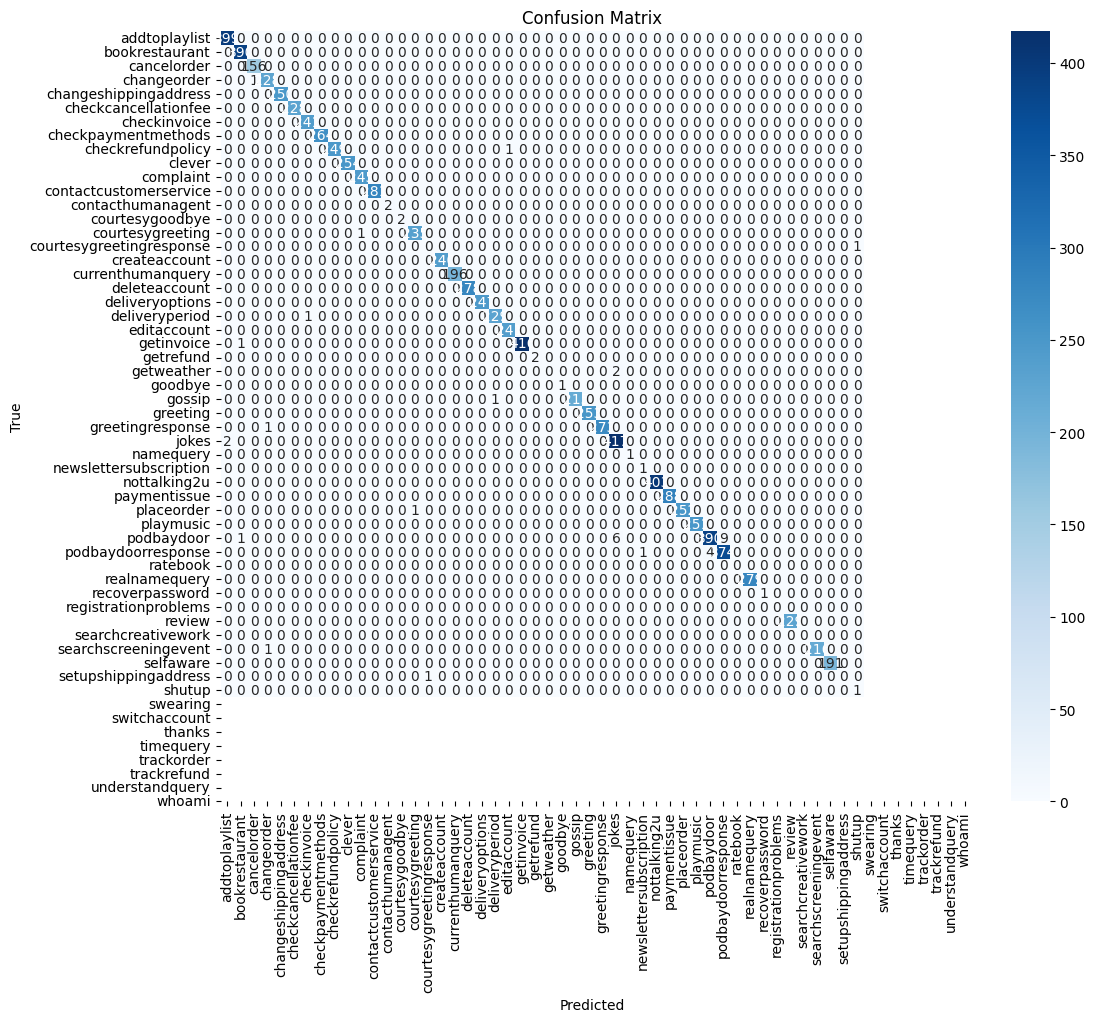

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()